In [1]:
!apt install -qq libgraphviz-dev
!pip install --quiet git+https://github.com/saezlab/codax.git

The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 21 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Selecting previously unselected package libgtk2.0-common.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack .../0-libgtk2.0-common_2.24.32-4ubuntu4_all.deb ...
Unpacking libgtk2.0-common (2.24.32-4ubuntu4) ...
Selecting previously unselected package libgtk2.0-0:amd64.
Preparing to unpack .../1-libgtk2.0-0_2.2

In [2]:
!wget https://raw.githubusercontent.com/saezlab/codax/main/codax/nn_cno/datasets/wcs_benchmark/MD-test.csv
!wget https://raw.githubusercontent.com/saezlab/codax/main/codax/nn_cno/datasets/wcs_benchmark/PKN-test.sif

--2023-02-16 10:57:27--  https://raw.githubusercontent.com/saezlab/codax/main/codax/nn_cno/datasets/wcs_benchmark/MD-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445 [text/plain]
Saving to: ‘MD-test.csv’

MD-test.csv         100%[===================>]     445  --.-KB/s    in 0s      

2023-02-16 10:57:27 (26.1 MB/s) - ‘MD-test.csv’ saved [445/445]

--2023-02-16 10:57:27--  https://raw.githubusercontent.com/saezlab/codax/main/codax/nn_cno/datasets/wcs_benchmark/PKN-test.sif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [3]:
from codax.nn_cno import ode
import warnings
import optax
import numpy as np
import matplotlib.pyplot as plt
import sympy2jax
import jax
import pandas as pd
warnings.filterwarnings('ignore')
jax.__version__, sympy2jax.__version__, optax.__version__

('0.3.25', '0.1.0', '0.1.4')

In [4]:
jax.devices()

[CpuDevice(id=0)]

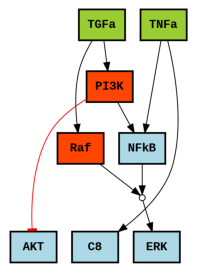

In [5]:
c = ode.logicODE("PKN-test.sif", "MD-test.csv")
c.preprocessing(compression=True,cutnonc=True,expansion=False)
c.plot_model()

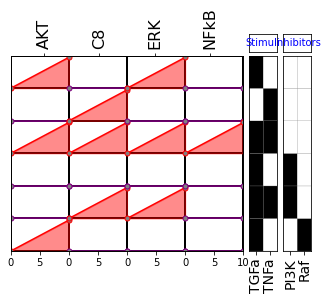

In [6]:
c.plot_midas();

In [7]:
opt_params = c.fit(max_iter=600, optimizer=optax.adam(learning_rate=1e-2))

  iter  	 current loss 	 min. loss	 grad norm
  0     	 1.3036e-01 	 1.3036e-01 	 3.1316e-01
  10    	 9.6200e-02 	 9.6200e-02 	 9.9148e-02
  20    	 8.7270e-02 	 8.7270e-02 	 9.3336e-02
  30    	 8.2477e-02 	 8.2477e-02 	 8.1660e-02
  40    	 7.8638e-02 	 7.8638e-02 	 6.1472e-02
  50    	 7.4248e-02 	 7.4248e-02 	 2.7459e-02
  60    	 6.7901e-02 	 6.7901e-02 	 7.2535e-02
  70    	 5.7533e-02 	 5.7533e-02 	 7.8934e-02
  80    	 8.0968e-02 	 5.4876e-02 	 1.1609e+02
  90    	 6.5754e+01 	 5.4876e-02 	 5.1267e+03
  iter  	 current loss 	 min. loss	 grad norm
  100   	 3.9363e+01 	 5.4876e-02 	 3.9657e+03
  110   	 3.1780e+00 	 5.4876e-02 	 1.1191e+03
  120   	 6.7863e-01 	 5.4876e-02 	 5.0274e+02
  130   	 1.5766e+00 	 5.4876e-02 	 7.8230e+02
  140   	 6.3806e-01 	 4.9099e-02 	 4.8644e+02
  150   	 1.1245e-01 	 4.7762e-02 	 1.6255e+02
  160   	 4.6888e-02 	 4.6888e-02 	 1.5299e+01
  170   	 5.7964e-02 	 4.6888e-02 	 6.8532e+01
  180   	 5.5444e-02 	 4.6350e-02 	 6.0966e+01
  190   	 4.961

In [8]:
# Sum of squared residuals, as in CNORode
c.sq_error_function(opt_params).sum()

DeviceArray(2.178311, dtype=float32)

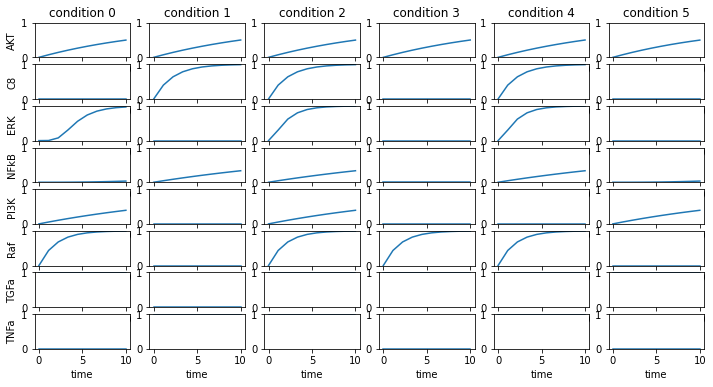

In [9]:
sim_res = c.simulate(ODEparameters=opt_params, timepoints=jax.numpy.linspace(0,10,10), plot_simulation=True)

In [11]:
# Test convergences for a given learning rate w/Adam

lr='1e-2'

for i in range(30):
    opt_params, results = c.fit(max_iter=3000, optimizer=optax.adam(learning_rate=float(lr)), get_results=True)
    df_results = pd.DataFrame(results)
    sse = []
    for params in df_results.best_params:
        sse.append(c.sq_error_function(params).sum().tolist())
    df_results['best_sse'] = sse
    df_results.to_csv(f'results_{lr}_{i}.csv')

Streaming output truncated to the last 5000 lines.
  2540  	 4.5228e-02 	 4.5228e-02 	 8.7607e-03
  2550  	 4.5228e-02 	 4.5228e-02 	 8.7595e-03
  2560  	 4.5228e-02 	 4.5228e-02 	 8.7919e-03
  2570  	 4.5228e-02 	 4.5228e-02 	 8.7740e-03
  2580  	 4.5228e-02 	 4.5228e-02 	 8.7562e-03
  2590  	 4.5228e-02 	 4.5228e-02 	 8.7718e-03
  iter  	 current loss 	 min. loss	 grad norm
  2600  	 4.5228e-02 	 4.5228e-02 	 8.7707e-03
  2610  	 4.5228e-02 	 4.5228e-02 	 8.7864e-03
  2620  	 4.5228e-02 	 4.5228e-02 	 8.7853e-03
  2630  	 4.5228e-02 	 4.5228e-02 	 8.7675e-03
  2640  	 4.5228e-02 	 4.5228e-02 	 8.8168e-03
  2650  	 4.5227e-02 	 4.5227e-02 	 8.8158e-03
  2660  	 4.5227e-02 	 4.5227e-02 	 8.7979e-03
  2670  	 4.5227e-02 	 4.5227e-02 	 8.8137e-03
  2680  	 4.5227e-02 	 4.5227e-02 	 8.8295e-03
  2690  	 4.5227e-02 	 4.5227e-02 	 8.8285e-03
  iter  	 current loss 	 min. loss	 grad norm
  2700  	 4.5227e-02 	 4.5227e-02 	 8.8275e-03
  2710  	 4.5227e-02 	 4.5227e-02 	 8.8265e-03
  2720  	 4